# **Train with cycleGAN Generated Image**

class: AD/CN (2)

data: cycleGAN generated image

data_path: /content/drive/MyDrive/Classfication 내에 두 가지 레이블 폴더로 구분

input_size: (224,224,3)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report,accuracy_score, confusion_matrix
from IPython.display import Markdown, display

In [3]:
dir_ = Path('/content/drive/MyDrive/Classification/generated')
filepaths = list(dir_.glob(r'**/*.png'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)

    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/Classification/generate...,CN
1,/content/drive/MyDrive/Classification/generate...,AD
2,/content/drive/MyDrive/Classification/generate...,CN
3,/content/drive/MyDrive/Classification/generate...,CN
4,/content/drive/MyDrive/Classification/generate...,CN


In [4]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 180

Number of different labels: 2

Labels: ['CN' 'AD']


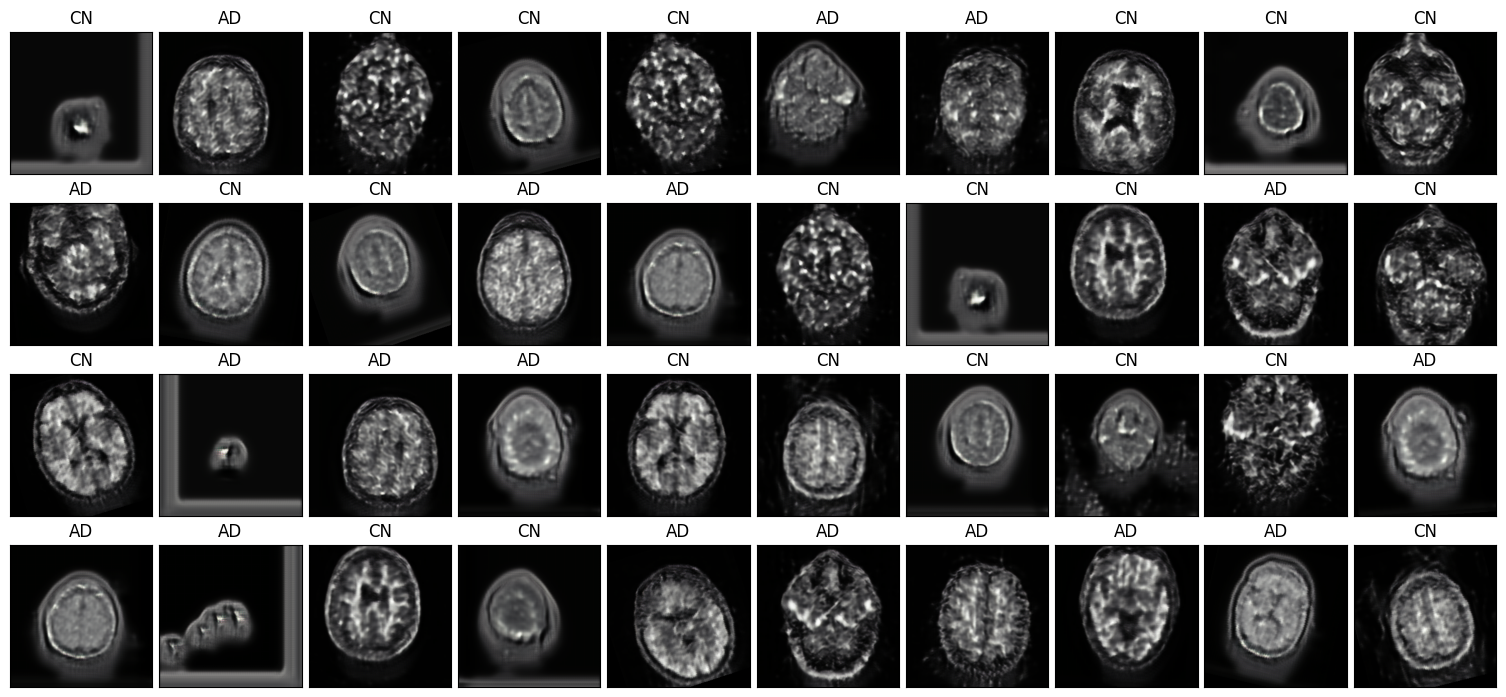

In [5]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

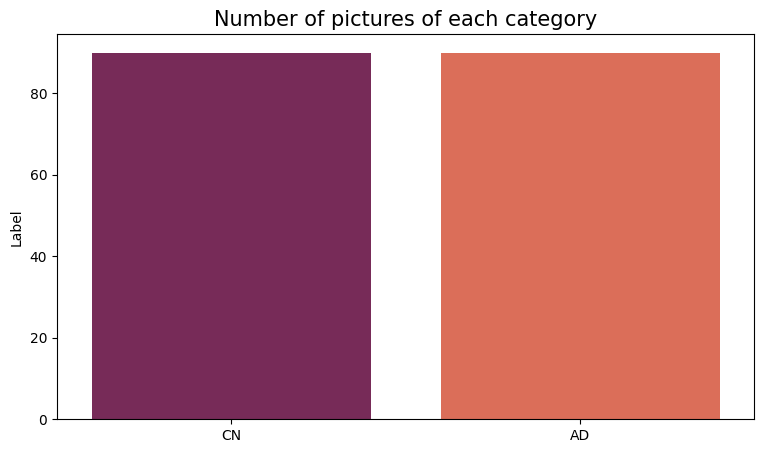

In [6]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [7]:
# Training/test split
# train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
train_df,test_df = train_test_split(df, test_size=0.2,random_state=0)
train_df.shape,test_df.shape

((144, 2), (36, 2))

In [8]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [9]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretrained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
    # 라벨 개수가 2개이기 때문에 Dence도 2로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Train모델 학습
for name, model in models.items():

    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=3,verbose=0)

    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 130 validated image filenames belonging to 2 classes.
Found 14 validated image filenames belonging to 2 classes.
Found 36 validated image filenames belonging to 2 classes.


29084464/29084464 [==============================] - 0s 0us/step
DenseNet121          trained in 111.09 sec
9406464/9406464 [==============================] - 0s 0us/step
MobileNetV2          trained in 29.18 sec
74836368/74836368 [==============================] - 1s 0us/step
DenseNet201          trained in 130.73 sec
16705208/16705208 [==============================] - 0s 0us/step
EfficientNetB0       trained in 50.47 sec
27018416/27018416 [==============================] - 0s 0us/step


EfficientNetB1       trained in 62.68 sec
87910968/87910968 [==============================] - 0s 0us/step


InceptionV3          trained in 82.63 sec
12683000/12683000 [==============================] - 0s 0us/step
MobileNetV3Large     trained in 24.04 sec
234545216/234545216 [==============================] - 3s 0us/step
ResNet152V2          trained in 239.37 sec
94765736/94765736 [==============================] - 1s 0us/step
ResNet50             trained in 129.67 sec
94668760/94668760 [==============================] - 0s 0us/step
ResNet50V2           trained in 116.03 sec
80134624/80134624 [==============================] - 0s 0us/step
VGG19                trained in 427.04 sec
58889256/58889256 [==============================] - 0s 0us/step
VGG16                trained in 367.01 sec
83683744/83683744 [==============================] - 0s 0us/step
Xception             trained in 112.92 sec


In [16]:
def visualize_confusion_matrix(y_test_bin, pred_bin, model_name):
    classes = [0, 1]
    con_mat = tf.math.confusion_matrix(labels=y_test_bin, predictions=pred_bin).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df = pd.DataFrame(con_mat_norm, index=classes, columns=classes)

    figure = plt.figure(figsize=(2, 2))
    sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

2/2 [==============================] - 6s 480ms/step
**DenseNet121 has a 72.22% accuracy on the test set**
Confusion Matrix for DenseNet121:
[[15  3]
 [ 7 11]]
2/2 [==============================] - 2s 187ms/step
**MobileNetV2 has a 75.00% accuracy on the test set**
Confusion Matrix for MobileNetV2:
[[11  7]
 [ 2 16]]
2/2 [==============================] - 16s 1s/step
**DenseNet201 has a 77.78% accuracy on the test set**
Confusion Matrix for DenseNet201:
[[14  4]
 [ 4 14]]
2/2 [==============================] - 5s 338ms/step
**EfficientNetB0 has a 50.00% accuracy on the test set**
Confusion Matrix for EfficientNetB0:
[[ 0 18]
 [ 0 18]]
2/2 [==============================] - 6s 439ms/step
**EfficientNetB1 has a 50.00% accuracy on the test set**
Confusion Matrix for EfficientNetB1:
[[18  0]
 [18  0]]
2/2 [==============================] - 10s 599ms/step
**InceptionV3 has a 72.22% accuracy on the test set**
Confusion Matrix for InceptionV3:
[[13  5]
 [ 5 13]]
2/2 [========================

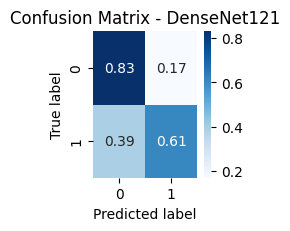

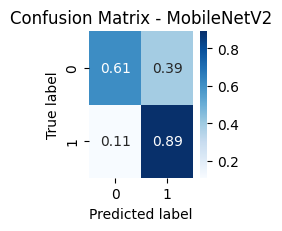

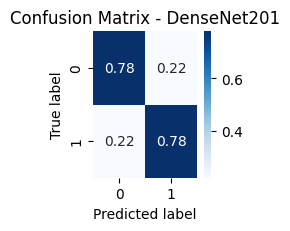

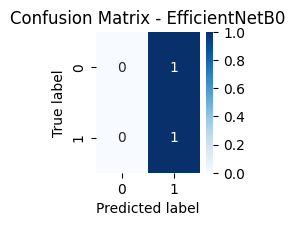

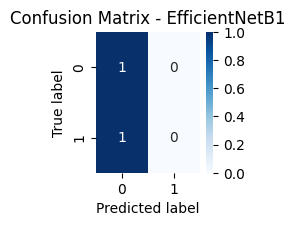

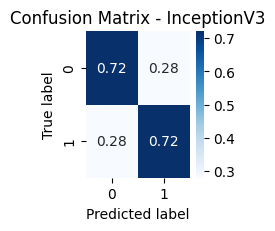

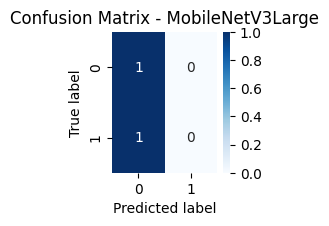

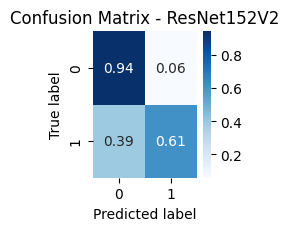

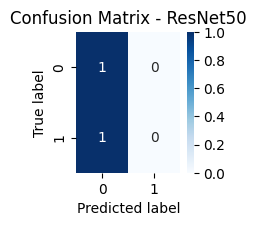

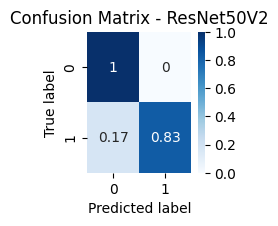

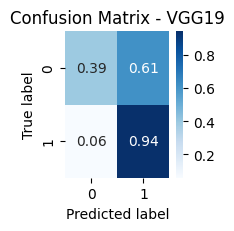

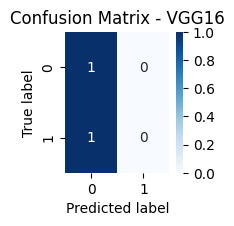

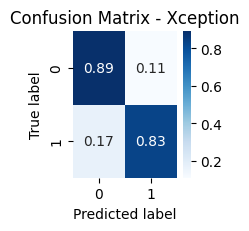

,model,f1 score,accuracy,Training time (sec),Confusion Matrix
0,ResNet50V2,0.9091,0.9167,116.03,"[[18, 0], [3, 15]]"
1,Xception,0.8571,0.8611,112.92,"[[16, 2], [3, 15]]"
2,DenseNet201,0.7778,0.7778,130.73,"[[14, 4], [4, 14]]"
3,ResNet152V2,0.7333,0.7778,239.37,"[[17, 1], [7, 11]]"
4,MobileNetV2,0.7805,0.7500,29.18,"[[11, 7], [2, 16]]"
5,DenseNet121,0.6875,0.7222,111.09,"[[15, 3], [7, 11]]"
6,InceptionV3,0.7222,0.7222,82.63,"[[13, 5], [5, 13]]"
7,VGG19,0.7391,0.6667,427.04,"[[7, 11], [1, 17]]"
8,EfficientNetB0,0.6667,0.5000,50.47,"[[0, 18], [0, 18]]"
9,EfficientNetB1,0.0000,0.5000,62.68,"[[18, 0], [18, 0]]"


In [20]:
# test데이터로 모델 성능 예측
for name, model in models.items():

    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)

    # Convert labels to binary format (0 or 1)
    y_test_bin = [1 if label == 'AD' else 0 for label in y_test]
    pred_bin = [1 if label == 'AD' else 0 for label in pred]

    acc = accuracy_score(y_test,pred)
    f1 = f1_score(y_test_bin, pred_bin)
    cm = confusion_matrix(y_test_bin, pred_bin)
    models[name]['acc'] = round(acc,4)
    models[name]['f1'] = round(f1, 4)
    models[name]['confusion_matrix'] = cm
    models[name]['y_test_bin'] = y_test_bin
    models[name]['pred_bin'] = pred_bin
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
    print(f'Confusion Matrix for {name}:\n{cm}')

# Create a DataFrame with the results
models_result = []

# 각 모델의 confusion matrix 출력
for name, v in models.items():
    visualize_confusion_matrix(models[name]['y_test_bin'], models[name]['pred_bin'], name)

for name, v in models.items():
    models_result.append([ name, models[name]['f1'],
                          models[name]['acc'],
                          models[name]['perf'],
                           models[name]['confusion_matrix']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','f1 score','accuracy','Training time (sec)', 'Confusion Matrix'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results


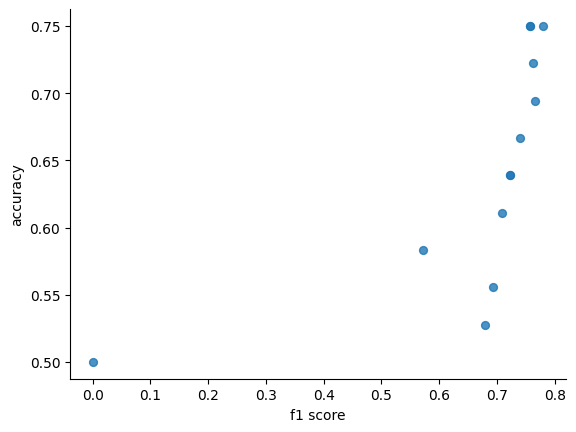

In [ ]:
from matplotlib import pyplot as plt
_df_23.plot(kind='scatter', x='f1 score', y='accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

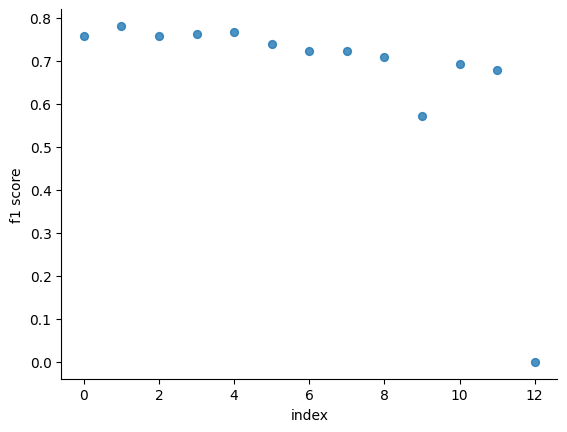

In [ ]:
from matplotlib import pyplot as plt
_df_22.plot(kind='scatter', x='index', y='f1 score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

# **Train with Original MRI/PET Image**

class: AD/CN (2)

data: cycleGAN generated image

data_path: /content/drive/MyDrive/classfication 내에 두 가지 레이블 폴더로 구분

input_size: (224,224,3)

In [21]:
dir_original = Path('/content/drive/MyDrive/Classification/original')
original_filepaths = list(dir_original.glob(r'**/*.png'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)

    return df

df = proc_img(original_filepaths)
df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/Classification/original...,AD
1,/content/drive/MyDrive/Classification/original...,CN
2,/content/drive/MyDrive/Classification/original...,AD
3,/content/drive/MyDrive/Classification/original...,AD
4,/content/drive/MyDrive/Classification/original...,AD


In [22]:
# Training/test split
# train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
original_train_df,original_test_df = train_test_split(df, test_size=0.2,random_state=0)
original_train_df.shape,original_test_df.shape

((144, 2), (36, 2))

In [23]:
def create_original_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=original_train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=original_train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=original_test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [24]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
original_train_generator,original_test_generator,original_train_images,original_val_images,original_test_images=create_original_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
    # 라벨 개수가 2개이기 때문에 Dencs도 2로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Train모델 학습
for name, model in models.items():

    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    # 모델 학습
    history = m.fit(original_train_images,validation_data=original_val_images,epochs=3,verbose=0)

    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 130 validated image filenames belonging to 2 classes.
Found 14 validated image filenames belonging to 2 classes.
Found 36 validated image filenames belonging to 2 classes.


DenseNet121          trained in 147.59 sec
MobileNetV2          trained in 33.93 sec
DenseNet201          trained in 168.4 sec
EfficientNetB0       trained in 64.8 sec
EfficientNetB1       trained in 73.87 sec
InceptionV3          trained in 61.97 sec
MobileNetV3Large     trained in 31.76 sec
ResNet152V2          trained in 238.8 sec
ResNet50             trained in 98.18 sec
ResNet50V2           trained in 89.02 sec
VGG19                trained in 427.5 sec
VGG16                trained in 248.26 sec
Xception             trained in 106.68 sec


2/2 [==============================] - 10s 457ms/step
**DenseNet121 has a 66.67% accuracy on the test set**
Confusion Matrix for DenseNet121:
[[16  2]
 [ 3 15]]
2/2 [==============================] - 2s 109ms/step
**MobileNetV2 has a 80.56% accuracy on the test set**
Confusion Matrix for MobileNetV2:
[[16  2]
 [ 3 15]]
2/2 [==============================] - 13s 714ms/step
**DenseNet201 has a 52.78% accuracy on the test set**
Confusion Matrix for DenseNet201:
[[16  2]
 [ 3 15]]
2/2 [==============================] - 4s 200ms/step
**EfficientNetB0 has a 50.00% accuracy on the test set**
Confusion Matrix for EfficientNetB0:
[[16  2]
 [ 3 15]]
2/2 [==============================] - 8s 287ms/step
**EfficientNetB1 has a 69.44% accuracy on the test set**
Confusion Matrix for EfficientNetB1:
[[16  2]
 [ 3 15]]
2/2 [==============================] - 5s 369ms/step
**InceptionV3 has a 58.33% accuracy on the test set**
Confusion Matrix for InceptionV3:
[[16  2]
 [ 3 15]]
2/2 [=====================

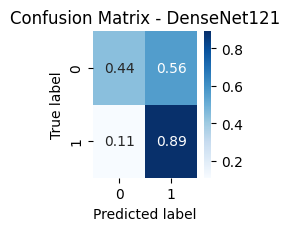

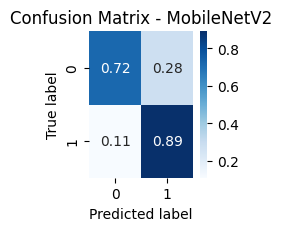

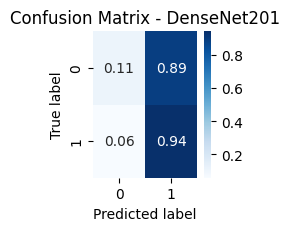

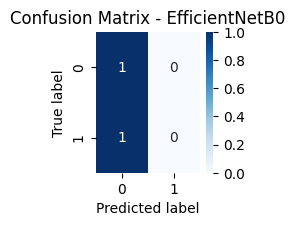

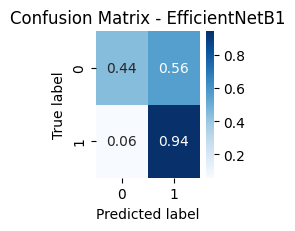

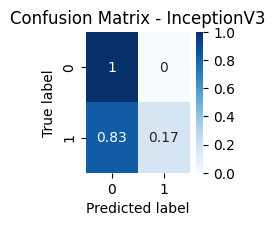

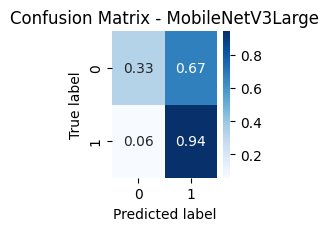

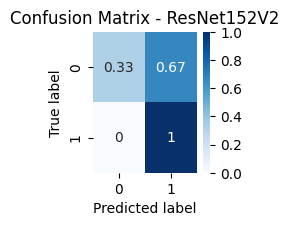

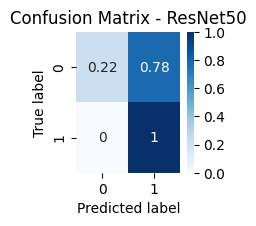

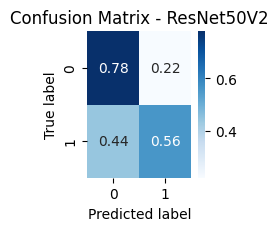

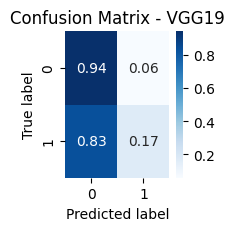

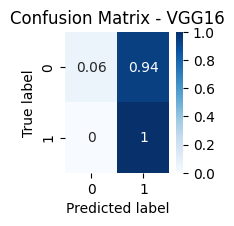

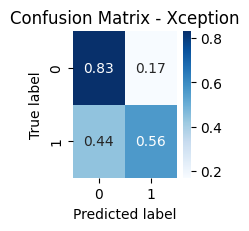

,model,f1 score,accuracy,Training time (sec),Confusion Matrix
0,MobileNetV2,0.8205,0.8056,33.93,"[[16, 2], [3, 15]]"
1,EfficientNetB1,0.7556,0.6944,73.87,"[[16, 2], [3, 15]]"
2,Xception,0.6452,0.6944,106.68,"[[16, 2], [3, 15]]"
3,DenseNet121,0.7273,0.6667,147.59,"[[16, 2], [3, 15]]"
4,ResNet152V2,0.7500,0.6667,238.80,"[[16, 2], [3, 15]]"
5,ResNet50V2,0.6250,0.6667,89.02,"[[16, 2], [3, 15]]"
6,MobileNetV3Large,0.7234,0.6389,31.76,"[[16, 2], [3, 15]]"
7,ResNet50,0.7200,0.6111,98.18,"[[16, 2], [3, 15]]"
8,InceptionV3,0.2857,0.5833,61.97,"[[16, 2], [3, 15]]"
9,VGG19,0.2727,0.5556,427.50,"[[16, 2], [3, 15]]"


In [25]:
# test데이터로 모델 성능 예측
for name, model in models.items():

    # Predict the label of the test_images
    pred = models[name]['model'].predict(original_test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (original_train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(original_test_df.Label)

    # Convert labels to binary format (0 or 1)
    y_test_bin = [1 if label == 'AD' else 0 for label in y_test]
    pred_bin = [1 if label == 'AD' else 0 for label in pred]

    acc = accuracy_score(y_test,pred)
    f1 = f1_score(y_test_bin, pred_bin)
    models[name]['acc'] = round(acc,4)
    models[name]['f1'] = round(f1, 4)
    models[name]['confusion_matrix'] = cm
    models[name]['y_test_bin'] = y_test_bin
    models[name]['pred_bin'] = pred_bin
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
    print(f'Confusion Matrix for {name}:\n{cm}')

# 각 모델의 confusion matrix 출력
for name, v in models.items():
    visualize_confusion_matrix(models[name]['y_test_bin'], models[name]['pred_bin'], name)

# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['f1'],
                          models[name]['acc'],
                          models[name]['perf'],
                           models[name]['confusion_matrix']])


df_results = pd.DataFrame(models_result,
                          columns = ['model','f1 score','accuracy','Training time (sec)', 'Confusion Matrix'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

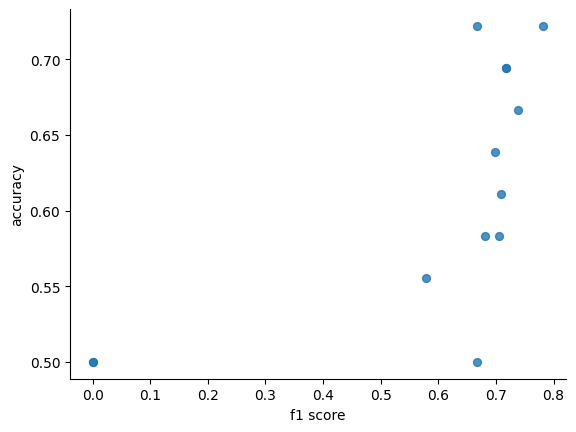

In [ ]:
from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='f1 score', y='accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

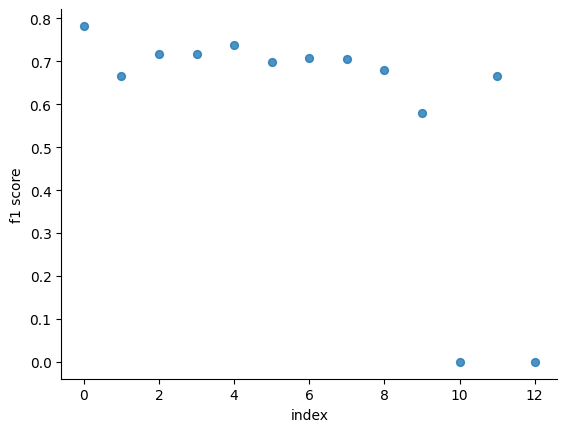

In [ ]:
from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='index', y='f1 score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)